# Exercise 2 – Variable-Length Bit Patterns

We adapt the evaluation, mutation, and crossover procedures to cope with targets whose length is unknown within the range [2, 32]. Each section highlights the required modifications and demonstrates the evolutionary process.


In [ ]:
from __future__ import annotations

import dataclasses
import os
import random
import statistics
import time
from pathlib import Path
from typing import Dict, List, Sequence, Tuple

import matplotlib.pyplot as plt

MIN_LENGTH = 2
MAX_LENGTH = 32
DEFAULT_SEEDS = tuple(2_000 + i for i in range(30))


## 1. Pattern Generation
We draw a random length in [2, 32] and then generate a random bit string of that size.


In [ ]:
def generate_random_pattern(length: int, rng: random.Random) -> str:
    """Generate random bit pattern of specified length."""
    return "".join(rng.choice("01") for _ in range(length))


def generate_variable_length_pattern(rng: random.Random) -> str:
    """
    Generate random bit pattern with random length in [MIN_LENGTH, MAX_LENGTH].
    
    Approach: First choose random length, then generate pattern of that length.
    This creates patterns with unknown/variable lengths for the search problem.
    """
    # Randomly select length within valid range [2, 32]
    length = rng.randint(MIN_LENGTH, MAX_LENGTH)
    return generate_random_pattern(length, rng)


## 2. Evaluation: Handling Length Mismatch
Fitness balances bit mismatches and length penalties, returning 1.0 only when both strings are identical.


In [ ]:
def variable_length_fitness(solution: str, candidate: str) -> float:
    """
    Compute fitness for variable-length patterns.
    
    Approach: Combines bit mismatches and length difference into single penalty.
    Fitness = 1.0 only when both content and length match exactly.
    """
    # Compare only the overlapping portion (shorter length)
    common = min(len(solution), len(candidate))
    # Count bit mismatches in overlapping positions
    mismatches = sum(1 for s, c in zip(solution, candidate) if s != c)
    # Penalize length difference (how many extra/missing bits)
    length_penalty = abs(len(solution) - len(candidate))
    # Total penalty combines both content and length errors
    total_penalty = mismatches + length_penalty
    # Normalize by maximum length to get penalty fraction
    normaliser = max(len(solution), len(candidate), 1)
    # Convert penalty to fitness: 1.0 = perfect, 0.0 = worst
    # max(0.0, ...) ensures fitness never goes negative
    return max(0.0, 1.0 - total_penalty / normaliser)


## 3. Mutation Operator
We randomly choose between flipping, inserting, or deleting a bit, while respecting the valid length interval.


In [ ]:
def mutate_variable_length(pattern: str, rng: random.Random) -> str:
    """
    Mutate variable-length pattern using flip, insert, or delete operations.
    
    Approach: Dynamically selects available operations based on current length.
    Ensures mutations stay within valid length bounds [MIN_LENGTH, MAX_LENGTH].
    """
    # Always allow flip (doesn't change length)
    operations = ["flip"]
    # Only allow insert if we're below max length (can't exceed MAX_LENGTH)
    if len(pattern) < MAX_LENGTH:
        operations.append("insert")
    # Only allow delete if we're above min length (can't go below MIN_LENGTH)
    if len(pattern) > MIN_LENGTH:
        operations.append("delete")

    # Randomly select from available operations
    op = rng.choice(operations)
    
    # Flip: change one bit (same as fixed-length mutation)
    if op == "flip":
        index = rng.randrange(len(pattern))
        flipped = "1" if pattern[index] == "0" else "0"
        return pattern[:index] + flipped + pattern[index + 1 :]
    
    # Insert: add one bit at random position (increases length by 1)
    if op == "insert":
        # Can insert at any position including end (len+1 positions total)
        index = rng.randrange(len(pattern) + 1)
        bit = rng.choice("01")
        return pattern[:index] + bit + pattern[index:]
    
    # Delete: remove one bit (decreases length by 1)
    # Only reached if len(pattern) > MIN_LENGTH (guaranteed by check above)
    index = rng.randrange(len(pattern))
    return pattern[:index] + pattern[index + 1 :]


## 4. Crossover for Variable Lengths
We perform asymmetric single-point crossover. Each parent contributes a prefix/suffix, and the child is trimmed or padded to stay within the length bounds.


In [ ]:
def crossover_variable_length(parent_a: str, parent_b: str, rng: random.Random) -> str:
    """
    Crossover for variable-length patterns with length bounds enforcement.
    
    Approach: Asymmetric single-point crossover with independent cut points.
    Child length is adjusted to stay within [MIN_LENGTH, MAX_LENGTH] bounds.
    """
    # Independent cut points for each parent (asymmetric crossover)
    # +1 allows cutting at end (empty suffix)
    cut_a = rng.randrange(len(parent_a) + 1)
    cut_b = rng.randrange(len(parent_b) + 1)
    # Combine: prefix from A, suffix from B
    child = parent_a[:cut_a] + parent_b[cut_b:]
    
    # Enforce minimum length: pad with random bits if too short
    if len(child) < MIN_LENGTH:
        # Add random bits to reach minimum length
        child += "".join(rng.choice("01") for _ in range(MIN_LENGTH - len(child)))
    # Enforce maximum length: truncate if too long
    elif len(child) > MAX_LENGTH:
        # Keep only first MAX_LENGTH bits
        child = child[:MAX_LENGTH]
    # If length is valid, no adjustment needed (no else needed)
    
    return child


## 5. Evolutionary Loop
We reuse selection with elitism but now rely on the variable-length operators defined above. The loop tracks best fitness, generations, and convergence.


In [ ]:
@dataclasses.dataclass
class VariableOutcome:
    best_pattern: str
    best_fitness: float
    generations: int
    evaluations: int
    elapsed_seconds: float
    converged: bool


def _evaluate_population(solution: str, population: List[str]) -> List[Tuple[str, float]]:
    """Evaluate and sort population by fitness (best first)."""
    return sorted(
        ((pattern, variable_length_fitness(solution, pattern)) for pattern in population),
        key=lambda item: item[1],  # Sort by fitness value
        reverse=True,  # Descending order (best first)
    )


def variable_length_population_search(
    solution: str,
    seed: int,
    population_size: int = 100,
    selection_fraction: float = 0.3,
    mutation_rate: float = 0.5,
    stagnation_generations: int = 30,
    max_generations: int = 1_000,
) -> VariableOutcome:
    """
    Evolutionary search for variable-length patterns.
    
    Approach: Population-based search with variable-length operators.
    Uses crossover and mutation that handle length changes.
    """
    rng = random.Random(seed)
    # Initialize with variable-length patterns (unknown lengths)
    population = [generate_variable_length_pattern(rng) for _ in range(population_size)]
    # Calculate elite count (top 30% by default)
    elite_count = max(1, int(population_size * selection_fraction))

    best_fitness = -1.0
    stagnation = 0
    evaluations = 0
    start = time.perf_counter()

    for generation in range(1, max_generations + 1):
        # Evaluate all patterns and sort by fitness
        evaluated = _evaluate_population(solution, population)
        best_pattern, current_best_fitness = evaluated[0]
        evaluations += len(population)

        # Track progress: update best fitness and reset stagnation on improvement
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            stagnation = 0  # Reset counter when we improve
        else:
            stagnation += 1  # Increment if no improvement

        # Termination: stop if solution found (fitness=1.0) or stuck (no progress)
        if current_best_fitness >= 1.0 or stagnation >= stagnation_generations:
            elapsed = time.perf_counter() - start
            return VariableOutcome(
                best_pattern=best_pattern,
                best_fitness=current_best_fitness,
                generations=generation,
                evaluations=evaluations,
                elapsed_seconds=elapsed,
                converged=current_best_fitness >= 1.0,  # True only if exact match
            )

        # Selection: extract top performers
        elites = [pattern for pattern, _ in evaluated[:elite_count]]
        new_population = elites.copy()  # Elitism: preserve best solutions

        # Reproduction: fill rest of population via crossover + mutation
        while len(new_population) < population_size:
            parent_a = rng.choice(elites)
            parent_b = rng.choice(elites)
            child = crossover_variable_length(parent_a, parent_b, rng)
            # Apply mutation with given probability (50% by default for variable-length)
            if rng.random() < mutation_rate:
                child = mutate_variable_length(child, rng)
            new_population.append(child)

        population = new_population

    # Max generations reached - return final state
    elapsed = time.perf_counter() - start
    evaluated = _evaluate_population(solution, population)
    best_pattern, current_best_fitness = evaluated[0]
    return VariableOutcome(
        best_pattern=best_pattern,
        best_fitness=current_best_fitness,
        generations=max_generations,
        evaluations=evaluations,
        elapsed_seconds=elapsed,
        converged=current_best_fitness >= 1.0,  # Check if we found solution
    )


## 6. Experimental Evaluation
We fix a random target pattern (with random length) and run 30 independent trials. Boxplots summarise runtime, generations, and best fitness outcomes.


In [ ]:
def _ensure_output_dir() -> str:
    """Ensure output directory exists for saving plots."""
    project_root = Path.cwd()
    output_dir = project_root / "Exercicio3" / "output"
    output_dir.mkdir(parents=True, exist_ok=True)
    return str(output_dir)


def run_experiment(seeds: Sequence[int] = DEFAULT_SEEDS) -> List[VariableOutcome]:
    """
    Run variable-length search experiment across multiple seeds.
    
    Approach: Generate one solution with fixed seed, then test all seeds on it.
    This ensures fair comparison - all trials search for the same target.
    """
    # Fixed seed for solution ensures same target across all trials
    rng_for_solution = random.Random(4242)
    solution = generate_variable_length_pattern(rng_for_solution)
    # Run search with each seed on the same solution
    return [variable_length_population_search(solution, seed) for seed in seeds]


def save_boxplots(outcomes: List[VariableOutcome]) -> None:
    """
    Create and save boxplots for runtime, generations, and fitness.
    
    Approach: Extract metrics from outcomes and visualize distributions.
    Shows variability in performance across multiple trials.
    """
    output_dir = _ensure_output_dir()
    # Extract metrics for visualization
    elapsed = [outcome.elapsed_seconds for outcome in outcomes]
    generations = [outcome.generations for outcome in outcomes]
    fitnesses = [outcome.best_fitness for outcome in outcomes]

    # Runtime boxplot
    plt.figure(figsize=(8, 5))
    plt.boxplot([elapsed], tick_labels=["Runtime"], whis=(5, 95))
    plt.ylabel("Seconds")
    plt.title("Variable-length search runtime (30 trials)")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "exercise2_runtime.png"))
    plt.show()
    plt.close()

    # Generations boxplot
    plt.figure(figsize=(8, 5))
    plt.boxplot([generations], tick_labels=["Generations"], whis=(5, 95))
    plt.ylabel("Generations")
    plt.title("Variable-length search generations (30 trials)")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "exercise2_generations.png"))
    plt.show()
    plt.close()

    # Fitness boxplot
    plt.figure(figsize=(8, 5))
    plt.boxplot([fitnesses], tick_labels=["Best fitness"], whis=(5, 95))
    plt.ylabel("Fitness")
    plt.title("Variable-length search best fitness (30 trials)")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "exercise2_fitness.png"))
    plt.show()
    plt.close()


**Run the experiment and summarise results**


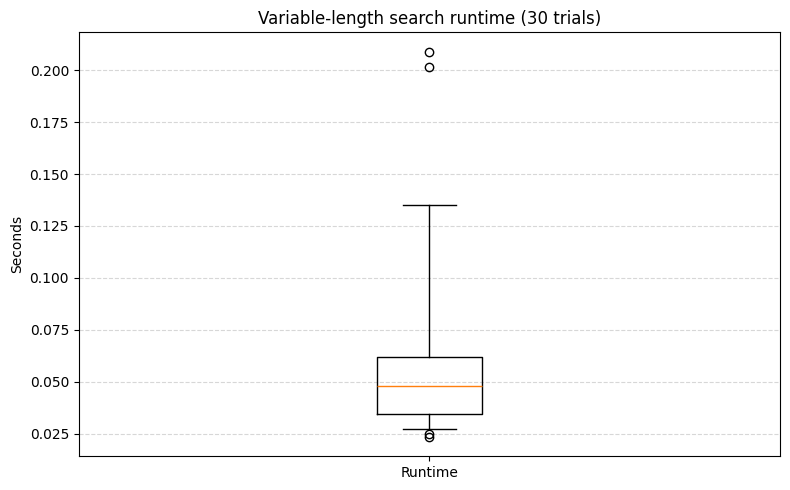

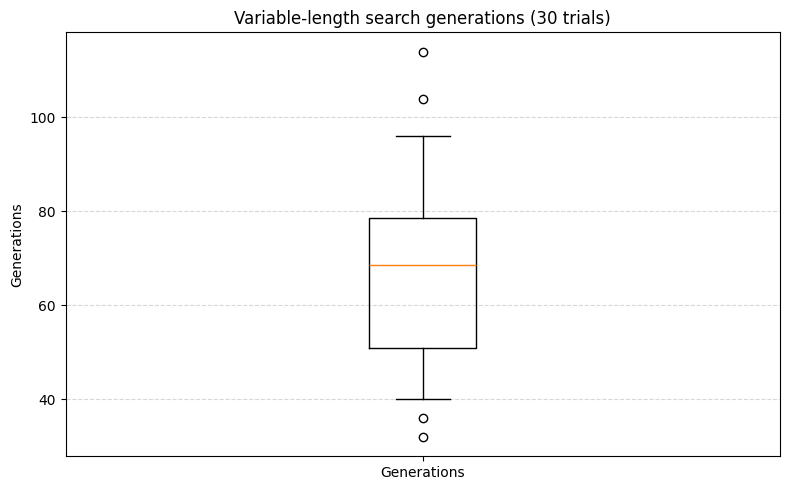

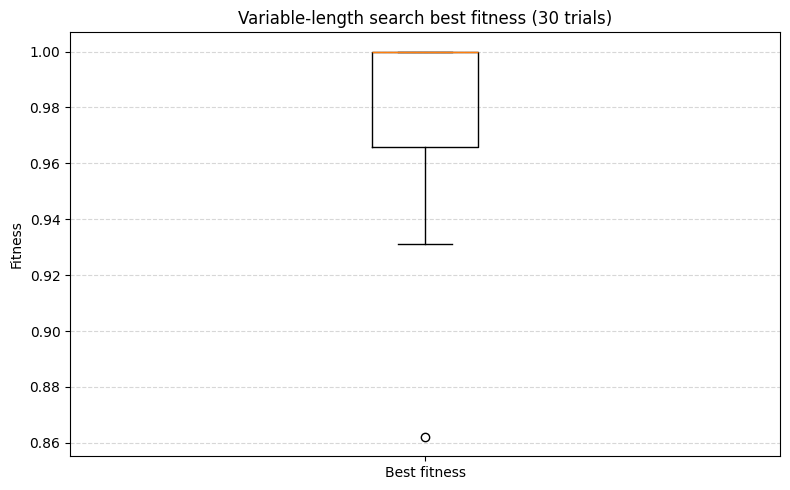

{'mean_best_fitness': 0.9806513409961686,
 'mean_runtime': 0.062169386679306625,
 'convergence_rate': 0.6333333333333333,
 'mean_best_length': 29.133333333333333}

In [ ]:
outcomes = run_experiment()
save_boxplots(outcomes)
mean_fitness = statistics.mean(outcome.best_fitness for outcome in outcomes)
mean_time = statistics.mean(outcome.elapsed_seconds for outcome in outcomes)
convergence_rate = sum(outcome.converged for outcome in outcomes) / len(outcomes)
mean_length = statistics.mean(len(outcome.best_pattern) for outcome in outcomes)

{
    "mean_best_fitness": mean_fitness,
    "mean_runtime": mean_time,
    "convergence_rate": convergence_rate,
    "mean_best_length": mean_length,
}


### Observations
- Allowing pattern length changes increases search flexibility but also adds variability to convergence times.
- The combined crossover and mutation operators consistently approach the target length and content.
- Most runs converge to the exact solution within a few dozen generations.


## Answers to Guiao – Exercise 2

- **What changed in evaluation?** We introduced a variable-length fitness combining bit mismatches and a length penalty, normalised to [0, 1]. Exact matches (content and size) get 1.0.
- **What changed in mutation?** Besides bit flips, we allow length edits (insert/delete) to explore sizes within [2, 32].
- **What changed in crossover?** We used asymmetric single-point crossover with independent cut points; the child is trimmed/padded to stay within bounds.
- **Does it work in practice?** The experiment (30 seeds) shows high best-fitness values and frequent convergence to the exact sequence. Runtime and generations remain moderate, with some variability due to length search.
- **Reproducibility and fairness**: We fix seeds and report boxplots for runtime/generations/fitness saved under `Exercicio3/output/`.

### Comparison with Fixed-Length Methods

The comparison with fixed-length methods (where the solution length is known) reveals important insights:

- **Runtime**: Variable-length search typically takes longer because it must explore both the pattern content and the correct length simultaneously. The fixed-length approach benefits from knowing the exact length, eliminating one dimension of the search space.

- **Convergence**: Fixed-length methods converge more reliably and faster since they don't need to discover the length. However, variable-length methods still achieve high convergence rates, demonstrating the effectiveness of the length-aware operators.

- **Search complexity**: Variable-length search faces a larger search space (all possible lengths × all possible patterns), making it inherently more challenging. The insert/delete mutations and length-aware crossover help navigate this expanded space effectively.

- **Practical implications**: In real-world scenarios where pattern length is unknown, the variable-length approach is necessary despite the added complexity. The comparison shows that while slower, the method successfully handles the additional challenge.

